In [ ]:
!pip install --upgrade numpy
!pip install --upgrade scipy
!pip install --upgrade gensim
!pip install tensorflow
!pip install keras

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.6 MB)
  A

In [ ]:

# ================================================
# EXPERIMEN: Word2Vec Dimension, Sequence Length, and Hidden Size on RNN vs LSTM
# ================================================
import numpy as np
import pandas as pd
import re
import nltk
import random
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:

# Load dataset from KaggleHub
df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "hassanamin/textdb3", "fake_or_real_news.csv")
df['label'] = df['label'].map({'REAL': 0, 'FAKE': 1})
df = df[['text', 'label']].dropna()

def clean_text(text):
    text = re.sub(r"[^a-zA-Z]", " ", str(text))
    tokens = text.lower().split()
    return [t for t in tokens if t not in stop_words]

df['tokens'] = df['text'].apply(clean_text)


<ipython-input-3-c2f55f0b0db2>:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "hassanamin/textdb3", "fake_or_real_news.csv")


In [ ]:

# Tokenizer setup
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tokens'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1


In [ ]:

# Define utility functions
def build_embedding_matrix(w2v_model, dim):
    matrix = np.zeros((vocab_size, dim))
    for word, i in word_index.items():
        if word in w2v_model.wv:
            matrix[i] = w2v_model.wv[word]
    return matrix


In [ ]:

# Experiment setup
embedding_dims = [50, 100, 200]
sequence_lengths = [50, 100, 200]
model_types = ['RNN', 'LSTM']
hidden_dims = [128, 256, 512]
results = []


In [7]:

# Start experiments
for emb_dim in embedding_dims:
    w2v = Word2Vec(sentences=df['tokens'], vector_size=emb_dim, window=5, min_count=2, workers=4, seed=SEED)
    embedding_matrix = build_embedding_matrix(w2v, emb_dim)

    for seq_len in sequence_lengths:
        sequences = tokenizer.texts_to_sequences(df['tokens'])
        X = pad_sequences(sequences, maxlen=seq_len)
        y = to_categorical(df['label'])

        X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
        X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_train_raw, y_train, test_size=0.2, random_state=SEED)

        for model_type in model_types:
            for hidden_dim in hidden_dims:
                print(f"Training {model_type} | dim={emb_dim} | seq={seq_len} | hidden={hidden_dim}")
                model = Sequential()
                model.add(Embedding(input_dim=vocab_size, output_dim=emb_dim, weights=[embedding_matrix], input_length=seq_len, trainable=False))
                if model_type == 'RNN':
                    model.add(SimpleRNN(hidden_dim))
                else:
                    model.add(LSTM(hidden_dim))
                model.add(Dense(2, activation='softmax'))
                model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
                model.fit(X_train_raw, y_train, validation_data=(X_val_raw, y_val), epochs=3, batch_size=64, verbose=0)

                y_pred = np.argmax(model.predict(X_test_raw), axis=1)
                y_true = np.argmax(y_test, axis=1)
                report = classification_report(y_true, y_pred, output_dict=True)

                results.append({
                    "Model": model_type,
                    "Embed_Dim": emb_dim,
                    "Seq_Len": seq_len,
                    "Hidden_Dim": hidden_dim,
                    "Accuracy": report["accuracy"],
                    "Precision": report["weighted avg"]["precision"],
                    "Recall": report["weighted avg"]["recall"],
                    "F1-Score": report["weighted avg"]["f1-score"]
                })


Training RNN | dim=50 | seq=50 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Training RNN | dim=50 | seq=50 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
Training RNN | dim=50 | seq=50 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
Training LSTM | dim=50 | seq=50 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Training LSTM | dim=50 | seq=50 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
Training LSTM | dim=50 | seq=50 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step
Training RNN | dim=50 | seq=100 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Training RNN | dim=50 | seq=100 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Training RNN | dim=50 | seq=100 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step
Training LSTM | dim=50 | seq=100 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
Training LSTM | dim=50 | seq=100 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step
Training LSTM | dim=50 | seq=100 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step
Training RNN | dim=50 | seq=200 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Training RNN | dim=50 | seq=200 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
Training RNN | dim=50 | seq=200 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step
Training LSTM | dim=50 | seq=200 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step
Training LSTM | dim=50 | seq=200 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step
Training LSTM | dim=50 | seq=200 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 438ms/step
Training RNN | dim=100 | seq=50 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Training RNN | dim=100 | seq=50 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
Training RNN | dim=100 | seq=50 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
Training LSTM | dim=100 | seq=50 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Training LSTM | dim=100 | seq=50 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
Training LSTM | dim=100 | seq=50 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step
Training RNN | dim=100 | seq=100 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Training RNN | dim=100 | seq=100 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Training RNN | dim=100 | seq=100 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step
Training LSTM | dim=100 | seq=100 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Training LSTM | dim=100 | seq=100 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step
Training LSTM | dim=100 | seq=100 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step
Training RNN | dim=100 | seq=200 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Training RNN | dim=100 | seq=200 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step
Training RNN | dim=100 | seq=200 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step
Training LSTM | dim=100 | seq=200 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step
Training LSTM | dim=100 | seq=200 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step
Training LSTM | dim=100 | seq=200 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 508ms/step
Training RNN | dim=200 | seq=50 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Training RNN | dim=200 | seq=50 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Training RNN | dim=200 | seq=50 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
Training LSTM | dim=200 | seq=50 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
Training LSTM | dim=200 | seq=50 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
Training LSTM | dim=200 | seq=50 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step
Training RNN | dim=200 | seq=100 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Training RNN | dim=200 | seq=100 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
Training RNN | dim=200 | seq=100 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step
Training LSTM | dim=200 | seq=100 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step
Training LSTM | dim=200 | seq=100 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step
Training LSTM | dim=200 | seq=100 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 283ms/step
Training RNN | dim=200 | seq=200 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
Training RNN | dim=200 | seq=200 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step
Training RNN | dim=200 | seq=200 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step
Training LSTM | dim=200 | seq=200 | hidden=128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step
Training LSTM | dim=200 | seq=200 | hidden=256


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step
Training LSTM | dim=200 | seq=200 | hidden=512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 581ms/step


In [8]:

# Convert results to DataFrame
df_results = pd.DataFrame(results)
display(df_results)


,Model,Embed_Dim,Seq_Len,Hidden_Dim,Accuracy,Precision,Recall,F1-Score
0,RNN,50,50,128,0.779795,0.779808,0.779795,0.779778
1,RNN,50,50,256,0.785320,0.790431,0.785320,0.784197
2,RNN,50,50,512,0.786109,0.786268,0.786109,0.786105
3,LSTM,50,50,128,0.831886,0.833830,0.831886,0.831709
4,LSTM,50,50,256,0.815312,0.821591,0.815312,0.814259
5,LSTM,50,50,512,0.836622,0.836844,0.836622,0.836616
6,RNN,50,100,128,0.722968,0.725141,0.722968,0.722478
7,RNN,50,100,256,0.693765,0.702846,0.693765,0.689787
8,RNN,50,100,512,0.705604,0.711673,0.705604,0.703097
9,LSTM,50,100,128,0.855564,0.859471,0.855564,0.855248


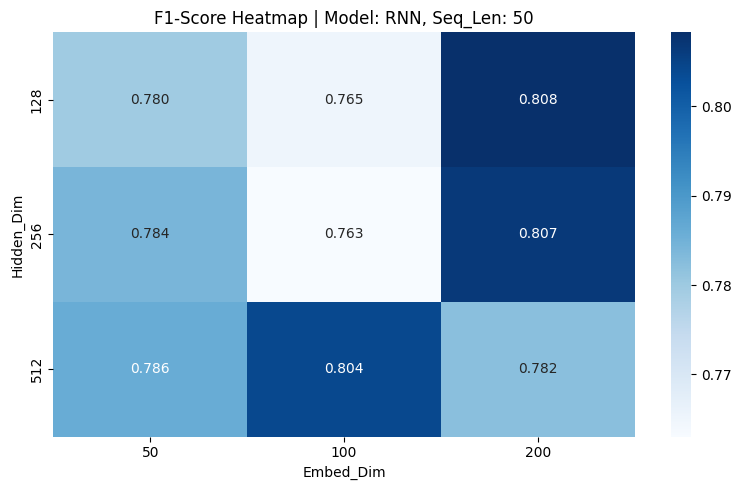

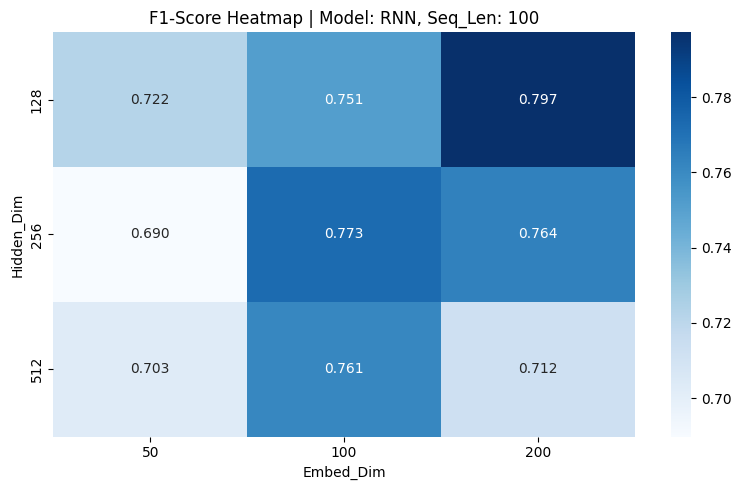

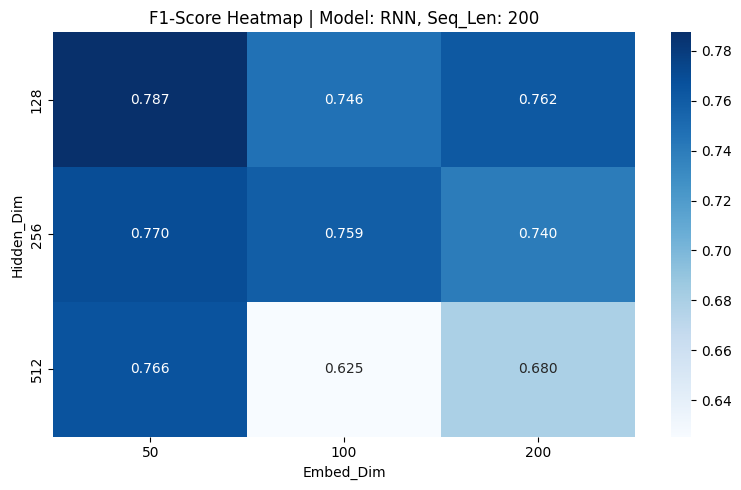

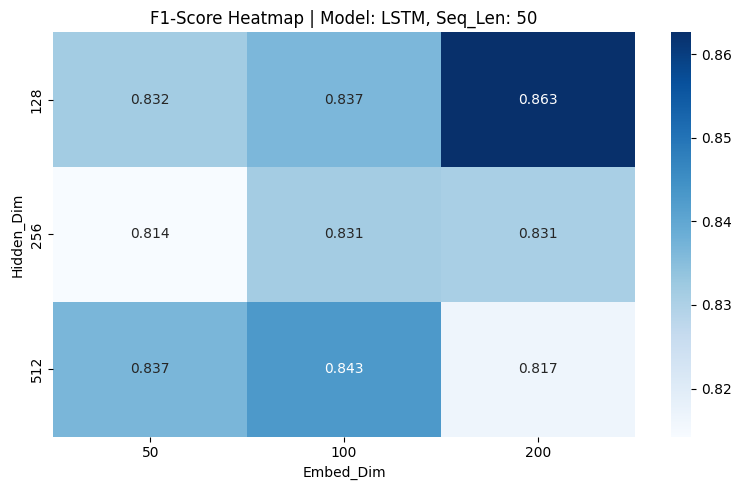

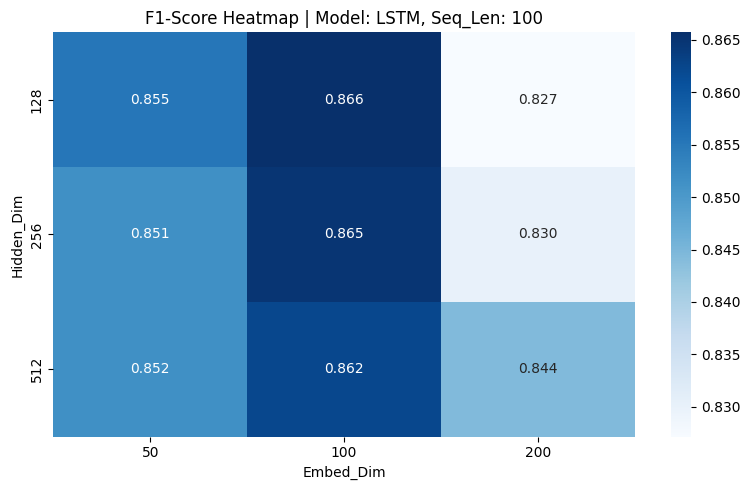

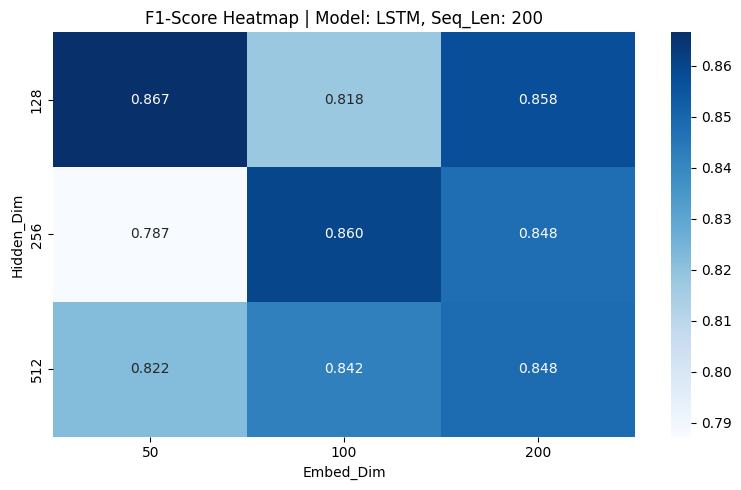

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results)

# F1-Score heatmap per Model + Embed_Dim + Seq_Len
for model in df_results['Model'].unique():
    for seq_len in sorted(df_results['Seq_Len'].unique()):
        subset = df_results[(df_results['Model'] == model) & (df_results['Seq_Len'] == seq_len)]
        pivot = subset.pivot(index='Hidden_Dim', columns='Embed_Dim', values='F1-Score')
        plt.figure(figsize=(8, 5))
        sns.heatmap(pivot, annot=True, cmap="Blues", fmt=".3f")
        plt.title(f"F1-Score Heatmap | Model: {model}, Seq_Len: {seq_len}")
        plt.xlabel("Embed_Dim")
        plt.ylabel("Hidden_Dim")
        plt.tight_layout()
        plt.show()

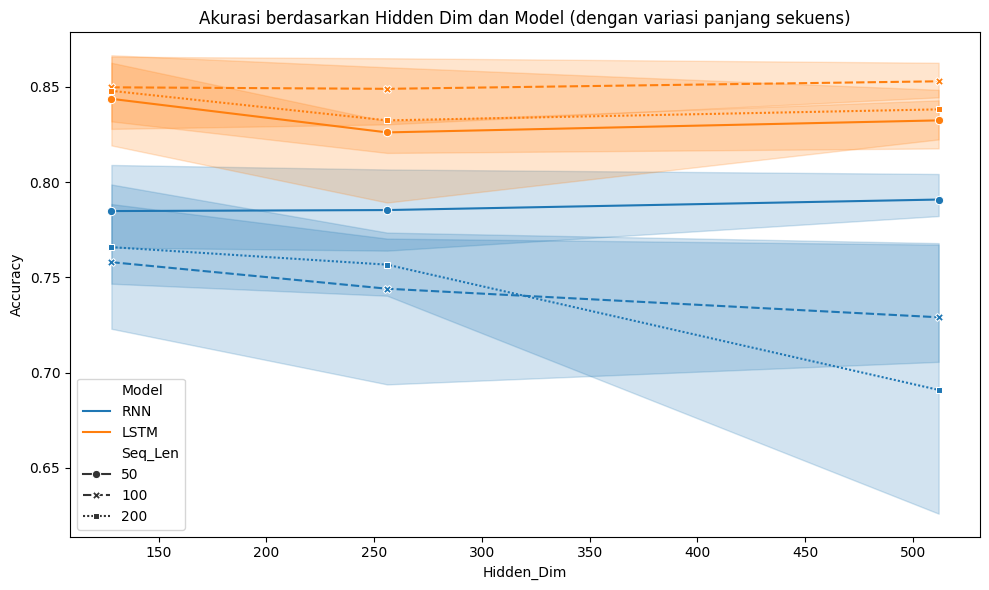

In [11]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x="Hidden_Dim", y="Accuracy", hue="Model", style="Seq_Len", markers=True)
plt.title("Akurasi berdasarkan Hidden Dim dan Model (dengan variasi panjang sekuens)")
plt.tight_layout()
plt.show()


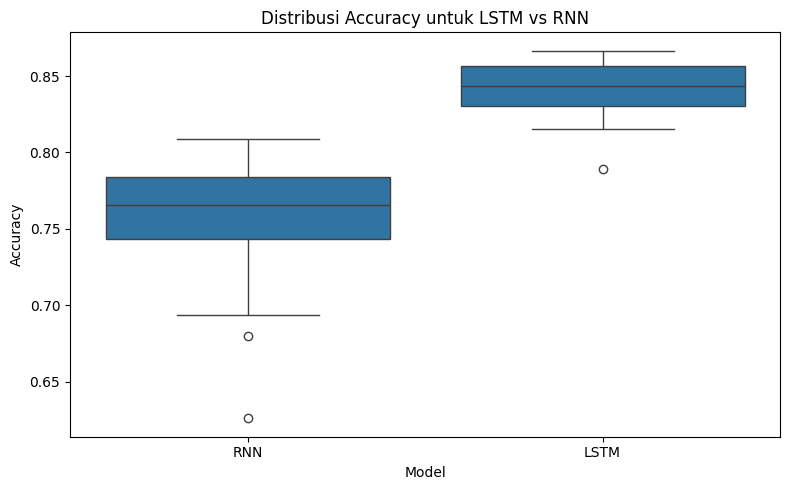

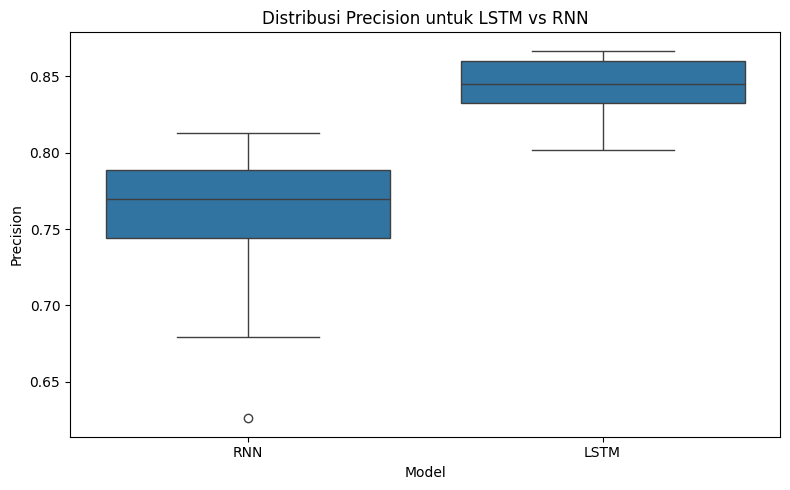

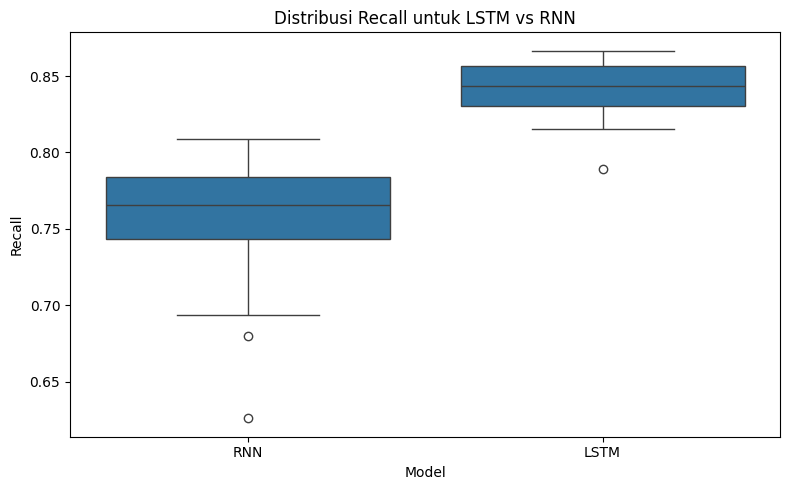

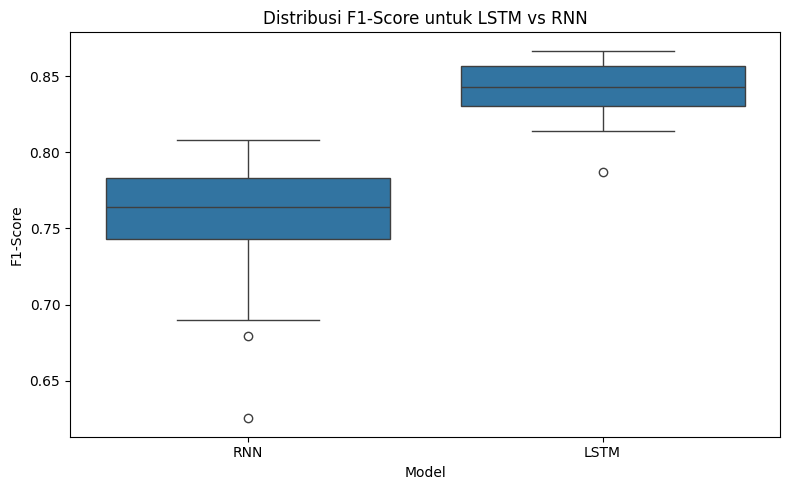

In [12]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_results, x='Model', y=metric)
    plt.title(f"Distribusi {metric} untuk LSTM vs RNN")
    plt.tight_layout()
    plt.show()


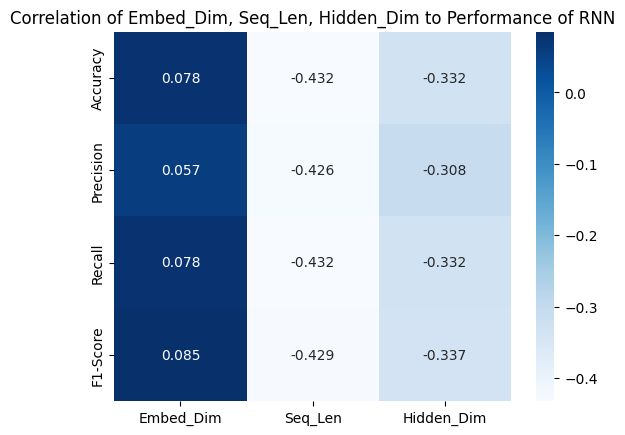

In [28]:
df_corr_rnn = df_results[df_results['Model'] == 'RNN'].iloc[:,1:].corr().loc[['Accuracy', 'Precision', 'Recall', 'F1-Score'],['Embed_Dim','Seq_Len','Hidden_Dim']]
sns.heatmap(df_corr_rnn, annot=True, cmap="Blues", fmt=".3f")
plt.title('Correlation of Embed_Dim, Seq_Len, Hidden_Dim to Performance of RNN')
plt.show()

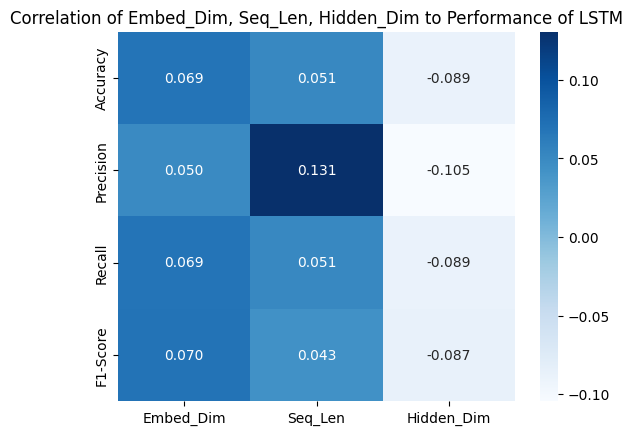

In [29]:
df_corr_lstm = df_results[df_results['Model'] == 'LSTM'].iloc[:,1:].corr().loc[['Accuracy', 'Precision', 'Recall', 'F1-Score'],['Embed_Dim','Seq_Len','Hidden_Dim']]
sns.heatmap(df_corr_lstm, annot=True, cmap="Blues", fmt=".3f")
plt.title('Correlation of Embed_Dim, Seq_Len, Hidden_Dim to Performance of LSTM')
plt.show()